# Reconstruction of a complex wavefunction

In this tutorial, a walkthrough of how to reconstruct a **complex** wavefunction via training a *Restricted Boltzmann Machine* (RBM), the neural network behind qucumber, will be presented.


## The wavefunction to be reconstructed
The simple wavefunction below describing two qubits (coefficients stored in *qubits_psi.txt*) will be reconstructed.

\begin{equation}
            \vert\psi \rangle = \alpha \vert00\rangle + \beta \vert 01\rangle + \gamma \vert10\rangle + \delta \vert11\rangle
\end{equation}

where the exact values of $\alpha, \beta, \gamma$ and $\delta$ used for this tutorial are 

\begin{align}
\alpha & = 0.2861  + 0.0539 i \\
\beta &  = 0.3687 - 0.3023 i \\
\gamma & = -0.1672 - 0.3529 i \\
\delta & = -0.5659 - 0.4639 i.
\end{align}

The example dataset, *qubits_train.txt*, comprises of 500 $\sigma$ measurements made in various bases (X, Y and Z). A corresponding file containing the bases for each data point in *qubits_train.txt*, *qubits_train_bases.txt*, is also required. As per convention, spins are represented in binary notation with zero and one denoting spin-down and spin-up, respectively.

## Using qucumber to reconstruct the wavefunction

### Imports
To begin the tutorial, first import the required Python packages.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from qucumber.nn_states import ComplexWaveFunction

from qucumber.callbacks import MetricEvaluator

import qucumber.utils.unitaries as unitaries
import qucumber.utils.cplx as cplx

import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data

The Python class *ComplexWaveFunction* contains generic properties of a RBM meant to reconstruct a complex wavefunction, the most notable one being the gradient function required for stochastic gradient descent.

To instantiate a *ComplexWaveFunction* object, one needs to specify the number of visible and hidden units in the RBM. The number of visible units, *num_visible*, is given by the size of the physical system, i.e. the number of spins or qubits (2 in this case), while the number of hidden units, *num_hidden*, can be varied to change the expressiveness of the neural network.

**Note:** The optimal *num_hidden* : *num_visible* ratio will depend on the system. For the two-qubit wavefunction described above, good results are yielded when this ratio is 1.

On top of needing the number of visible and hidden units, a *ComplexWaveFunction* object requires the user to input a dictionary containing the unitary operators (2x2) that will be used to rotate the qubits in and out of the computational basis, Z, during the training process. The *unitaries* utility will take care of creating this dictionary.

The *MetricEvaluator* class and *training_statistics* utility are built-in amenities that will allow the user to evaluate the training in real time. 

Lastly, the *cplx* utility allows qucumber to be able to handle complex numbers. Currently, Pytorch does not support complex numbers.


### Training
To evaluate the training in real time, the fidelity between the true wavefunction of the system and the wavefunction that qucumber reconstructs, $\vert\langle\psi\vert\psi_{RBM}\rangle\vert^2$, will be calculated along with the Kullback-Leibler (KL) divergence (the RBM's cost function). First, the training data and the true wavefunction of this system need to be loaded using the *data* utility.

In [2]:
train_path = "qubits_train.txt"
train_bases_path = "qubits_train_bases.txt"
psi_path = "qubits_psi.txt"
bases_path = "qubits_bases.txt"

train_samples, true_psi, train_bases, bases = data.load_data(
    train_path, psi_path, train_bases_path, bases_path
)

The file *qubits_bases.txt* contains every unique basis in the *qubits_train_bases.txt* file. Calculation of the full KL divergence in every basis requires the user to specify each unique basis.

As previouosly mentioned, a *ComplexWaveFunction* object requires a dictionary that contains the unitariy operators that will be used to rotate the qubits in and out of the computational basis, Z, during the training process. In the case of the provided dataset, the unitaries required are the well-known $H$, and $K$ gates. The dictionary needed can be created with the following command.

In [3]:
unitary_dict = unitaries.create_dict()
# unitary_dict = unitaries.create_dict(unitary_name=torch.tensor([[real part],
#                                                                 [imaginary part]],
#                                                                 dtype=torch.double)

If the user wishes to add their own unitary operators from their experiment to *unitary_dict*, uncomment the block above. When *unitaries.create_dict()* is called, it will contain the identity and the $H$ and $K$ gates by default with the keys "Z", "X" and "Y", respectively.

The number of visible units in the RBM is equal to the number of qubits. The number of hidden units will also be taken to be the number of visible units.

In [4]:
nv = train_samples.shape[-1]
nh = nv

nn_state = ComplexWaveFunction(
    num_visible=nv, num_hidden=nh, unitary_dict=unitary_dict, gpu=False
)
# nn_state = ComplexWaveFunction(num_visible=nv, num_hidden=nh, unitary_dict=unitary_dict)

By default, qucumber will attempt to run on a GPU if one is available (if one is not available, qucumber will default to CPU). If one wishes to run qucumber on a CPU, add the flag "gpu = False" in the *ComplexWaveFunction* object instantiation. Uncomment the line above to run this tutorial on a GPU.

Now the hyperparameters of the training process can be specified. 

1. **epochs**: the total number of training cycles that will be performed (default = 100)
2. **pos_batch_size**: the number of data points used in the positive phase of the gradient (default = 100)
3. **neg_batch_size**: the number of data points used in the negative phase of the gradient (default = *pos_batch_size*)
4. **k**: the number of contrastive divergence steps (default = 1)
5. **lr**: the learning rate (default = 0.001)

    **Note:** For more information on the hyperparameters above, it is strongly encouraged that the user to read through the brief, but thorough theory document on RBMs. One does not have to specify these hyperparameters, as their default values will be used without the user overwriting them. It is recommended to keep with the default values until the user has a stronger grasp on what these hyperparameters mean. The quality and the computational efficiency of the training will highly depend on the choice of hyperparameters. As such, playing around with the hyperparameters is almost always necessary. 
    
The two-qubit example in this tutorial should be extremely easy to train, regardless of the choice of hyperparameters. However, the hyperparameters below will be used.

In [5]:
epochs = 100
pbs = 50  # pos_batch_size
nbs = 50  # neg_batch_size
lr = 0.1
k = 5

For evaluating the training in real time, the *MetricEvaluator* will be called to calculate the training evaluators every 10 epochs. The *MetricEvaluator* requires the following arguments.

1. **log_every**: the frequency of the training evaluators being calculated is controlled by the *log_every* argument (e.g. *log_every* = 200 means that the *MetricEvaluator* will update the user every 200 epochs)
2. A dictionary of functions you would like to reference to evaluate the training (arguments required for these functions are keyword arguments placed after the dictionary)

The following additional arguments are needed to calculate the fidelity and KL divergence in the *training_statistics* utility.

- **target_psi** (the true wavefunction of the system)
- **space** (the hilbert space of the system)

The training evaluators can be printed out via the *verbose=True* statement.

Although the fidelity and KL divergence are excellent training evaluators, they are not practical to calculate in most cases; the user may not have access to the target wavefunction of the system, nor may generating the hilbert space of the system be computationally feasible. However, evaluating the training in real time is extremely convenient. 

Any custom function that the user would like to use to evaluate the training can be given to the *MetricEvaluator*, thus avoiding having to calculate fidelity and/or KL divergence. As an example, functions that calculate the the norm of each of the reconstructed wavefunction's coefficients are presented. Any custom function given to *MetricEvaluator* must take the neural-network state (in this case, the *ComplexWaveFunction* object) and keyword arguments. Although the given example requires the hilbert space to be computed, the scope of the *MetricEvaluator*'s ability to be able to handle any function should still be evident.

In [6]:
def alpha(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.compute_normalization(space).sqrt_()
    alpha_ = cplx.norm(
        torch.tensor([rbm_psi[0][0], rbm_psi[1][0]], device=nn_state.device)
        / normalization
    )

    return alpha_


def beta(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.compute_normalization(space).sqrt_()
    beta_ = cplx.norm(
        torch.tensor([rbm_psi[0][1], rbm_psi[1][1]], device=nn_state.device)
        / normalization
    )

    return beta_


def gamma(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.compute_normalization(space).sqrt_()
    gamma_ = cplx.norm(
        torch.tensor([rbm_psi[0][2], rbm_psi[1][2]], device=nn_state.device)
        / normalization
    )

    return gamma_


def delta(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.compute_normalization(space).sqrt_()
    delta_ = cplx.norm(
        torch.tensor([rbm_psi[0][3], rbm_psi[1][3]], device=nn_state.device)
        / normalization
    )

    return delta_

Now the hilbert space of the system must be generated for the fidelity and KL divergence and the dictionary of functions the user would like to compute every "*log_every*" epochs must be given to the *MetricEvaluator*.

In [7]:
log_every = 2
space = nn_state.generate_hilbert_space(nv)

callbacks = [
    MetricEvaluator(
        log_every,
        {
            "Fidelity": ts.fidelity,
            "KL": ts.KL,
            "normα": alpha,
#             "normβ": beta,
#             "normγ": gamma,
#             "normδ": delta,
        },
        target_psi=true_psi,
        bases=bases,
        verbose=True,
        space=space,
    )
]

Now the training can begin. The *ComplexWaveFunction* object has a property called *fit* which takes care of this.

In [8]:
nn_state.fit(
    train_samples,
    epochs=epochs,
    pos_batch_size=pbs,
    neg_batch_size=nbs,
    lr=lr,
    k=k,
    input_bases=train_bases,
    callbacks=callbacks,
)

Epoch: 2	Fidelity = 0.174375	KL = 0.508918	normα = 0.378294
Epoch: 4	Fidelity = 0.309861	KL = 0.372534	normα = 0.250289
Epoch: 6	Fidelity = 0.403572	KL = 0.320281	normα = 0.208634
Epoch: 8	Fidelity = 0.468801	KL = 0.291631	normα = 0.195250
Epoch: 10	Fidelity = 0.532876	KL = 0.263887	normα = 0.192293
Epoch: 12	Fidelity = 0.602205	KL = 0.229315	normα = 0.200809
Epoch: 14	Fidelity = 0.684060	KL = 0.181441	normα = 0.209185
Epoch: 16	Fidelity = 0.763912	KL = 0.127602	normα = 0.235120
Epoch: 18	Fidelity = 0.835485	KL = 0.082226	normα = 0.248662
Epoch: 20	Fidelity = 0.882996	KL = 0.055797	normα = 0.252744
Epoch: 22	Fidelity = 0.912324	KL = 0.041223	normα = 0.262147
Epoch: 24	Fidelity = 0.931488	KL = 0.033419	normα = 0.257988
Epoch: 26	Fidelity = 0.944448	KL = 0.028757	normα = 0.247959
Epoch: 28	Fidelity = 0.954234	KL = 0.024283	normα = 0.257282
Epoch: 30	Fidelity = 0.960887	KL = 0.021704	normα = 0.253166
Epoch: 32	Fidelity = 0.966974	KL = 0.019072	normα = 0.260652
Epoch: 34	Fidelity = 0.96999

All of these training evaluators can be accessed after the training has completed, as well. The code below shows this, along with plots of each training evaluator versus the training cycle number (epoch).

In [9]:
fidelities = callbacks[0].Fidelity
KLs = callbacks[0].KL
coeffs = callbacks[0].normα
# Please note that the key given to the *MetricEvaluator* must be what comes after callbacks[0].
epoch = np.arange(log_every, epochs + 1, log_every)

In [10]:
# Some parameters to make the plots look nice
params = {'text.usetex': True,
            'font.family': 'serif',
            'legend.fontsize': 14,
            'figure.figsize': (10, 3),
            'axes.labelsize': 16,
            'xtick.labelsize':14,
            'ytick.labelsize':14,
            'lines.linewidth':2,
            'lines.markeredgewidth': 0.8,
            'lines.markersize': 5,
            'lines.marker': "o",
            "patch.edgecolor": "black"
         }
plt.rcParams.update(params)
plt.style.use('seaborn-deep')

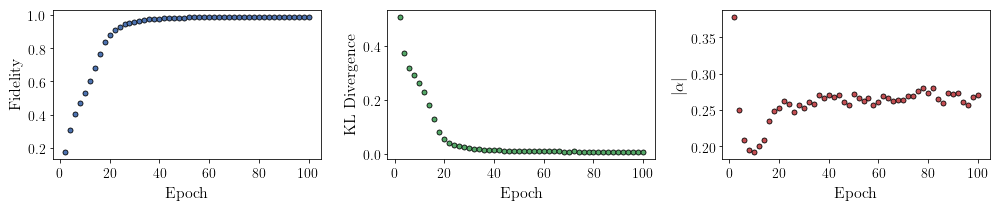

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 3))
ax = axs[0]
ax.plot(epoch, fidelities, "o", color = "C0", markeredgecolor="black")
ax.set_ylabel(r'Fidelity')
ax.set_xlabel(r'Epoch')

ax = axs[1]
ax.plot(epoch, KLs, "o", color = "C1", markeredgecolor="black")
ax.set_ylabel(r'KL Divergence')
ax.set_xlabel(r'Epoch')

ax = axs[2]
ax.plot(epoch, coeffs, "o", color = "C2", markeredgecolor="black")
ax.set_ylabel(r'$\vert\alpha\vert$')
ax.set_xlabel(r'Epoch')

plt.tight_layout()
plt.savefig("complex_fid_KL.pdf")
plt.show()

It should be noted that one could have just ran *nn_state.fit(train_samples)* and just used the default hyperparameters and no training evaluators.

At the end of the training process, the network parameters (the weights, visible biases and hidden biases) are stored in the *ComplexWaveFunction* object. One can save them to a pickle file, which will be called *saved_params.pt*, with the following command.

In [12]:
nn_state.save("saved_params.pt")

This saves the weights, visible biases and hidden biases as torch tensors with the following keys: "weights", "visible_bias", "hidden_bias".